# Сегментация изображений

* Датасеты
* Метрики
* Модели
* Практика

## Постановка задачи

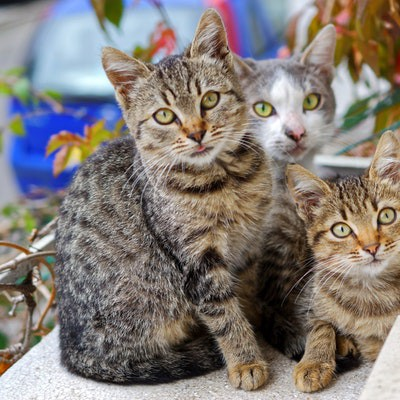

**Object Detection**

Найти объект это значит найти такой минимальный прямоугольник, который будет вмещать в себя объект целиком. То есть для каждого котика на изображении мы хотим знать, что это котик, и координаты прямоугольника, описывающего нашего котика.

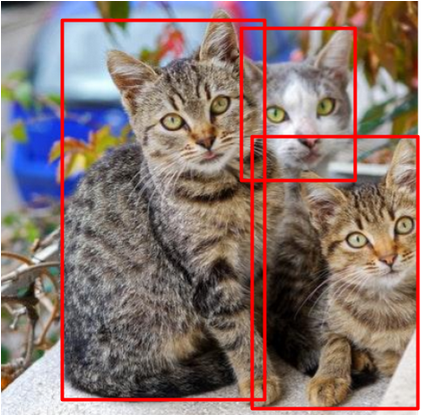

**Instance Segmentation** 

Допустим, что мы хотим помимо прямоугольника узнать еще и форму объекта. Тогда нам на помощь приходит задача Instance segmentation. Теперь для каждого котика мы хотим иметь:

- класс (в данном случае котик)
- bounding box
- бинарную маску


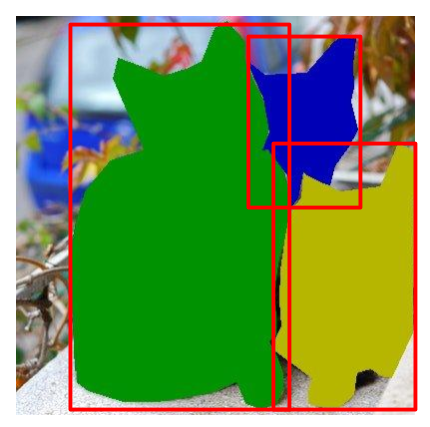

**Semantic Segmentation**

Мы хотим отнести каждый пиксель изображения к какому-то из классов. К примеру, наши котики будут одним классом, фон другим, тротуар, на котором они сидят - третьим.

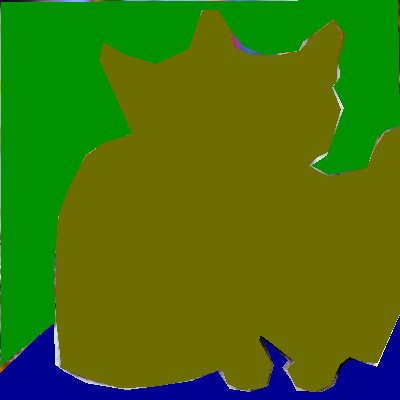

**Panoptic Segmentation**

Это комбинация Instance Segmentation и Semantic Segmentation.

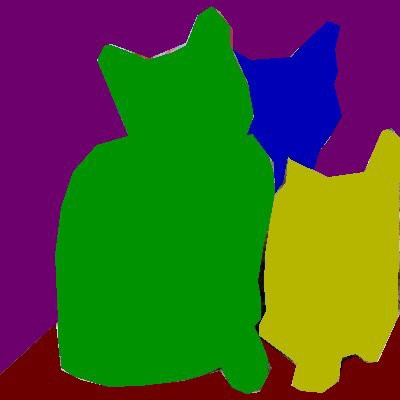

---

## Датасеты


### Cityscapes

https://www.cityscapes-dataset.com/

* 30 классов
* 20000 изображений с аннотациями

![](./imgs/cityscapes.png)

### ADE-20K

https://groups.csail.mit.edu/vision/datasets/ADE20K/index.html

* 25574 изображения в обучающей выборке
* 2000 изображений в валидационной выборке

![](./imgs/ade20k.png)

### Pascal VOC

[Pascal VOC 2012](http://host.robots.ox.ac.uk/pascal/VOC/)

Ссылка на [статью](http://host.robots.ox.ac.uk/pascal/VOC/pubs/everingham15.pdf)

Датасет содержит:
* 20 классов
* Набор train + val содержит 11,530 картинок, 27,450 ROI  и 6,929 сегментационных масок. 
* Картинки различных размеров и качества





![](./imgs/voc.png)

### MSCOCO Common Objects in Context
 

[Сайт](https://cocodataset.org/) датасета.

[Статья](https://arxiv.org/abs/1405.0312)

Датасет содержит:
* 80 классов
* Train: 118K (18GB) картинок
* Val: 5K (1GB) картинок
* Test: 41K (6GB) картинок



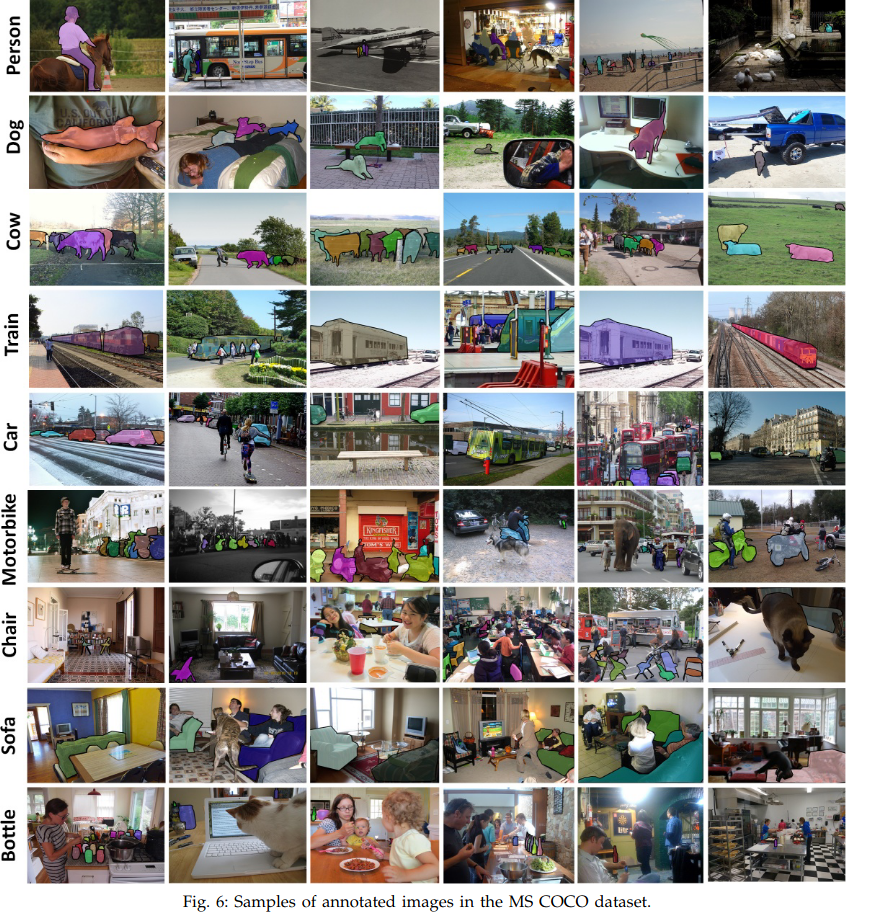

---

## Метрики

### Pixel accuracy

\begin{align}
PA = \frac{TP + TN}{TP + TN + FP + FN}
\end{align}


![](./imgs/pixacc.png)

Простая метрика чувствительная к дисбалансу классов.

### IoU

Для подсчета данной метрики нам необъодимо взять два bounding box-а. Посчитаем площадь объединениея, площадь пересечения и возьмем отношение площади пересечения к площади объединения. Это и есть IoU.

\begin{align}
IoU = \frac{TP}{TP + FP + FN}
\end{align}


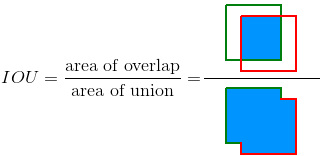

### Dice Coefficient

\begin{align}
Dice = \frac{2TP}{2TP + FP + FN}
\end{align}


![](./imgs/dice.png)

IoU сколнна к более низкой оценке, можно провести аналогию с L1 и L2, где L2 аналогичная IoU ("считает квадрат ошибки"), IoU ближе по смыслу к оценке худшей ошибки, Dice - к средней.

![](./imgs/diceiou.png)

---

# Модели

## Общая идея:

![](./imgs/seg.png)

[Советую посмотреть лекицию](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf)

### Mask R-CNN

[Статья](https://arxiv.org/pdf/1703.06870.pdf)

Модель выполняет детекцию как и Fast-RCNN, а также предсказывает сегментационную маску для каждой области интереса. <br>
Для повышения точности место операции RoiPool используется операция RoiAlign. <br>
Про сравнение операций можно почитать [здесь](https://erdem.pl/2020/02/understanding-region-of-interest-part-2-ro-i-align).

![](./imgs/maskrcnn.png)

## U-Net

[Статья](https://arxiv.org/pdf/1505.04597.pdf)

![](./imgs/unet.png)

## DeepLab

[Статья](https://arxiv.org/pdf/1606.00915.pdf)

![](./imgs/deeplab.png)

Dilated (Atrous) convolution:

![](./imgs/dilated.gif)

Atrous Spatial Pyramid Pooling

![](./imgs/afpp.png)

---

# Практика

Выполним семантическую сегментацию для классов пешеход и машина на датасете Cityscapes. <br>

Скачать датасет можно по [ссылке_1](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs) 
или [ссылке_2](https://drive.google.com/file/d/1XzdQusVDCt4ZETYLSXT-aBr9NYiTlrG5/view?usp=share_link).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/datasest/semantic_segm_data.zip -q

In [ ]:
import os
import random
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

import albumentations as albu
from skimage.transform import resize

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

from typing import Dict

In [ ]:
DATA_PATH = './semantic_segm_data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')

Посмотрим на данные:

In [ ]:
def plot_samples(path):
    samples = os.listdir(path)

    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    ax = ax.ravel()

    for s in range(len(ax)):
        random_sample = np.random.choice(samples)
        path_to_sample = os.path.join(path, random_sample)
        sample = Image.open(path_to_sample)
        ax[s].imshow(sample)
    fig.tight_layout()

In [ ]:
plot_samples(TRAIN_PATH)

Цветовое обозначение классов:

In [ ]:
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

labels = {
    'person': (220, 20, 60),
    'rider': (255, 0, 0),
    'car': (0, 0, 142),
    'truck': (0, 0, 70),
    'bus': (0, 60, 100),
    'caravan': (0, 0, 90),
    'trailer': (0, 0, 110)
}

In [ ]:
labels_range = {
    'human': [(200, 0, 0), (255, 40, 80)],
    'car': [(0, 0, 60), (20, 70, 160)]
}

Проверим наши маски:

In [ ]:
def get_sample(path):
    samples = os.listdir(path)
    random_sample = np.random.choice(samples)
    path_to_sample = os.path.join(path, random_sample)
    sample = np.asanyarray(Image.open(path_to_sample))
    return sample

In [ ]:
def create_mask(sample, labels_range, erode_dilate=False):
    h, w, _ = sample.shape
    mask = np.zeros((h, w))

    for c, label in enumerate(labels_range.keys()):
        idxs = np.where(np.logical_and(
            np.all(sample <= labels_range[label][1], axis=-1),
            np.all(sample >= labels_range[label][0], axis=-1))
        )
        mask[idxs[0], idxs[1]] = c + 1

    if erode_dilate:
        kernel = np.ones((2, 2), dtype='uint8')
        mask = cv2.erode(mask, kernel, iterations=1)
        kernel = np.ones((3, 3), dtype='uint8')
        mask = cv2.dilate(mask, kernel, iterations=1)

    return mask


def test_masking(path, labels_range):
    fig, ax = plt.subplots(3, 3, figsize=(16, 8), sharey=True)
    for i in range(3):
        sample = get_sample(path)
        tgt = sample[:, 256:, :]
        mask = create_mask(tgt, labels_range, erode_dilate=False)
        mask_d = create_mask(tgt, labels_range, erode_dilate=True)

        ax[i][0].imshow(tgt)
        ax[i][1].imshow(mask)
        ax[i][2].imshow(mask_d)

    ax[0][0].set_title('Original')
    ax[0][1].set_title('From range')
    ax[0][2].set_title('With erode-dilate')

In [ ]:
test_masking(TRAIN_PATH, labels_range)

Создадим датасет и трансформации:

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self,
                 path: str,
                 transforms=None):
        super().__init__()
        self.path = path
        self.transforms = transforms
        self.data_list = os.listdir(path)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path_to_img = os.path.join(self.path, self.data_list[idx])
        img = np.asanyarray(Image.open(path_to_img), dtype='uint8')

        x = img[:, :256, :]
        y = img[:, 256:, :]

        if self.transforms:
            x, y = self.transforms(x, y)

        x = torch.from_numpy(x).type(torch.float32)
        y = torch.from_numpy(y).type(torch.long)

        return x, y

In [ ]:
class TargetMask:
    def __init__(self,
                 labels_range: Dict,
                 erosion_kernel: tuple,
                 dilation_kernel: tuple):
        self.labels_range = labels_range
        self.erosion_kernel = erosion_kernel
        self.dilation_kernel = dilation_kernel

    def create_mask(self, y):
        h, w, _ = y.shape
        mask = np.zeros((h, w))
        for c, label in enumerate(self.labels_range.keys()):
            idxs = np.where(np.logical_and(
                np.all(y <= self.labels_range[label][1], axis=-1),
                np.all(y >= self.labels_range[label][0], axis=-1))
            )
            mask[idxs[1], idxs[0]] = c + 1

        if self.erosion_kernel:
            kernel = np.ones(self.erosion_kernel, dtype='uint8')
            mask = cv2.erode(mask, kernel, iterations=1)  
        if self.dilation_kernel:
            kernel = np.ones(self.dilation_kernel, dtype='uint8')
            mask = cv2.dilate(mask, kernel, iterations=1)     

        return mask

    def __call__(self, x, y):
        y = self.create_mask(y)
        return x, y

In [ ]:
class Normalize:
    def __init__(self):
        self.norm = albu.Normalize()

    def __call__(self, x, y):
        out = self.norm(image=x)
        x = out['image']
        return x, y


class Resize:
    def __init__(self,
                 out_size: tuple):
        self.out_size = out_size

    def __call__(self, x, y):
        x = resize(x, self.out_size)
        y = resize(y, self.out_size)
        return x, y


class Augmentations:
    def __init__(self,
                 p_flip: float):
        self.flip = albu.Flip(p=p_flip)

    def __call__(self, x, y):
        aug_dict = self.flip(image=x, mask=y)
        x = aug_dict['image']
        y = aug_dict['mask']
        return x, y


class MoveAxis:
    def __init__(self):
        pass

    def __call__(self, x, y):
        x = np.moveaxis(x, -1, 0)
        y = np.moveaxis(y, -1, 0)
        return x, y


class Compose:
    def __init__(self,
                 transforms: list):
        self.transforms = transforms

    def __call__(self, x, y):
        for t in self.transforms:
            x, y = t(x, y)
        return x, y

Напишем реализацию U-Net:

In [ ]:
class Block(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(n_in, n_out, 2),
            nn.ReLU(),
            nn.Conv2d(n_out, n_out, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Encoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.encoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        features = []
        for block in self.encoder_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
        return features


class Decoder(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.Tconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i+1], 2, 2) for i in range(len(channels)-1)]
        )

    def crop(self, x, features):
        _, _, w, h = x.shape
        return transforms.CenterCrop([w, h])(features)

    def forward(self, x, features):
        for i, block in enumerate(self.decoder_blocks):
            x = self.Tconvs[i](x)
            features_for_cat = self.crop(x, features[i])
            x = torch.cat([x, features_for_cat], dim=1)
            x = block(x)
        return x


class UNet(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.encoder = Encoder(cfg['encoder_channels'])
        self.decoder = Decoder(cfg['decoder_channels'])
        self.head = nn.Conv2d(cfg['decoder_channels'][-1], cfg['n_classes'], 1)
        self.retain_dim = cfg['retain_dim']
        self.out_size = cfg['out_size']

    def forward(self, x):
        encoded_features = self.encoder(x)
        decoded_features = self.decoder(encoded_features[::-1][0],
                                        encoded_features[::-1][1:])
        res = self.head(decoded_features)
        if self.retain_dim:
            res = F.interpolate(res, self.out_size)
        return res

In [ ]:
def train_monitor(losses_train, losses_train_mean, losses_val):

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))

        iters = np.arange(len(losses_train))
        n_vals = len(losses_val)
        step = int(len(losses_train) / n_vals)
        val_steps = np.linspace(step, step*n_vals, n_vals)

        for i in range(2):
            ax[i].plot(iters, losses_train, linewidth=1.5, alpha=0.6,
                       c='tab:blue', label='train loss')
            ax[i].plot(iters, losses_train_mean, linewidth=2, alpha=1,
                       c='tab:blue', label='avg10 train loss')
            ax[i].plot(val_steps, losses_val, linewidth=2, alpha=1,
                       c='tab:red', label='val loss')
            ax[i].set_ylabel('CrossEntropy loss')
            ax[i].set_xlabel('Iteration')
            ax[i].legend()
            ax[i].grid()
            if i == 1:
                ax[i].set_yscale('log')
        plt.show()

In [ ]:
def forward(model, x, y, criterion, device):
    x = x.to(device)
    y = y.to(device)
    prd = model(x)
    loss = criterion(prd, y)
    return loss, prd


def evaluate(model, dataloader, device, criterion):
    losses = []
    model.eval()
    with torch.no_grad():
        val_iter = iter(dataloader)
        for i in range(len(dataloader)):
            x, y = next(val_iter)
            loss, _ = forward(model, x, y, criterion, device)
            losses.append(loss.item())
    return np.mean(losses)


def train_model(model,
                train_dataloader,
                val_dataloader,
                device,
                optimizer,
                criterion,
                scheduler,
                cfg):

    losses_train, losses_train_mean = [], []
    losses_val = []
    loss_val = None
    best_val_loss = 1e6

    writer = SummaryWriter()

    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(cfg['n_iter']))

    for i in progress_bar:
        try:
            x, y = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            x, y = next(tr_it)

        model.train()
        torch.set_grad_enabled(True)
        loss, _ = forward(model, x, y, criterion, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        losses_train_mean.append(np.mean(losses_train[-1:-10:-1]))
        progress_bar.set_description(f'loss: {loss.item():.5f}, avg loss: {np.mean(losses_train):.5f}')
        writer.add_scalar('loss_train', loss.item(), i)

        if i % cfg['n_iter_val'] == 0:
            loss_val = evaluate(model, val_dataloader, device, criterion)
            losses_val.append(loss_val)
            progress_bar.set_description(f'val_loss: {loss_val:.5f}')
            writer.add_scalar('loss_val', loss_val, i)

        if scheduler:
            if scheduler.__class__.__name__ == 'ReduceLROnPlateau' and loss_val:
                scheduler.step(loss_val)
            else:
                scheduler.step()
            writer.add_scalar('lr', optimizer.param_groups[0]['lr'], i)

        clear_output(True)
        if cfg['plot_mode']:
            train_monitor(losses_train, losses_train_mean, losses_val)

        if cfg['save_best_val'] and loss_val < best_val_loss:
            best_val_loss = loss_val
            checkpoint_path = cfg['checkpoint_path']
            torch.save(model.state_dict(),
                       f'{checkpoint_path}/{model.__class__.__name__}_{loss_val:.3f}.pth')

    writer.close()

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
!mkdir weights

In [ ]:
# CONFIGS 

dl_cfg = {
    'erosion_kernel': (2, 2),
    'dilation_kernel': (3, 3),
    'img_size': (256, 256),
    'p_flip': 0.5,
    'bs': 32,
    'labels_range': {'human': [(190, 0, 0), (255, 60, 100)],
                     'car': [(0, 0, 60), (20, 70, 160)]},
}

unet_cfg = {
    'encoder_channels': (3, 64, 128, 256, 512),
    'decoder_channels': (512, 256, 128, 64),
    'n_classes': 3,
    'retain_dim': True,
    'out_size': (256, 256)
}

train_cfg = {
    'lr': 1e-3,
    'n_iter': 2000,
    'n_iter_val': 50,
    'class_weights': [0.1, 0.6, 0.3],
    'plot_mode': True,
    'save_best_val': True,
    'checkpoint_path': './weights'
}

In [ ]:
transforms_train = Compose(
    [Normalize(),
     Augmentations(dl_cfg['p_flip']),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     MoveAxis()]
)

transforms_val = Compose(
    [Normalize(),
     TargetMask(dl_cfg['labels_range'],
                dl_cfg['erosion_kernel'],
                dl_cfg['dilation_kernel']),
     MoveAxis()]
)

dataset_train = SegmentationDataset(TRAIN_PATH, transforms_train)
dataset_val = SegmentationDataset(VAL_PATH, transforms_val)

dataloader_train = DataLoader(dataset_train, dl_cfg['bs'], shuffle=True)
dataloader_val = DataLoader(dataset_val, dl_cfg['bs'], shuffle=True)


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

unet = UNet(unet_cfg).to(device)

optimizer = optim.Adam(unet.parameters(), lr=train_cfg['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.9, verbose=True)

w = torch.Tensor(train_cfg['class_weights']).type(torch.float32).to(device)
criterion = nn.CrossEntropyLoss(w)


In [ ]:
train_model(unet,
            dataloader_train,
            dataloader_val,
            device,
            optimizer,
            criterion,
            scheduler,
            train_cfg)


In [ ]:
def predict_mask(model, img, device):
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        mask_prd = model(img)
    mask_prd = mask_prd.argmax(dim=1)
    mask_prd = mask_prd.cpu().numpy()
    return mask_prd

In [ ]:
val_it = iter(dataloader_train)
x, y = next(val_it)

pred_mask_unet = predict_mask(unet, x, device)

In [ ]:
def x_to_img(x):
    x = x.permute(1, 2, 0).cpu().numpy() 
    x = (x * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    x = (x*255).astype(np.int64)
    return x

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8), sharey=True)

for i in range(3):
  ax[i][0].imshow(x_to_img(x[i]))
  ax[i][1].imshow(y[i])
  ax[i][2].imshow(pred_mask_unet[i])
  for j, title in enumerate(['Input image', 'GT', 'Prd UNet']):
    ax[0][j].set_title(title)
    ax[i][j].grid(False)